In [1]:
train_id = "1YA2UaEnTY592-x7Cr1-3Xfw4D3F0yp2B" 
!gdown https://drive.google.com/uc?id={train_id}

test_id = "1zjjf9cWGTpve-bGFgrhBVQOazmAAMlkY" 
!gdown https://drive.google.com/uc?id={test_id}

!ls -ltr

Downloading...
From: https://drive.google.com/uc?id=1YA2UaEnTY592-x7Cr1-3Xfw4D3F0yp2B
To: /content/train.csv
302MB [00:02, 148MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zjjf9cWGTpve-bGFgrhBVQOazmAAMlkY
To: /content/test.csv
302MB [00:02, 146MB/s]
total 589516
drwxr-xr-x 1 root root      4096 Aug 27 16:17 sample_data
-rw-r--r-- 1 root root 302133017 Sep 22 13:36 train.csv
-rw-r--r-- 1 root root 301526706 Sep 22 13:36 test.csv


In [2]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from imblearn.over_sampling import SVMSMOTE, SMOTE, RandomOverSampler
from imblearn.combine import SMOTETomek
import xgboost as xgb
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from inspect import signature

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# Modelling

## Data Preprocessing

In [3]:
#reading the train set in pd dataframe
df = pd.read_csv('train.csv')
df.head()
print(df.shape)

(200000, 202)


In [4]:
#no missing values
df.isnull().values.any()

False

0    179902
1     20098
Name: target, dtype: int64


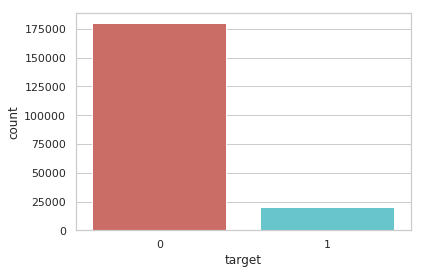

In [5]:
#extremely imbalance -about a 9:1 ratio
print(df['target'].value_counts())
sns.countplot(x='target', data=df, palette='hls')
plt.show()

In [6]:
#splitting between input variables and target variables 
#removing ID_code and target from input varaibles
X = df.iloc[:, 2:]
Y  = df.loc[:, df.columns == 'target']
X.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,3.8743,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.8160,3.6783,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,10.8917,0.9003,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,9.1738,0.6665,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,19.3038,1.4450,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [0]:
#splitting between training and validation  
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=123)
col = list(X_train)
y_1d = np.ravel(y_train)

rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_1d)

In [0]:
X_train = pd.DataFrame(data=X_rus, columns=col)
y_train = pd.DataFrame(data=y_rus, columns=['target'])

## Training XGB

### Model Fitting

In [0]:
#using special data matrix for xgboosting algorithm
xgdmat = xgb.DMatrix(X_train, y_train)
#parameters for model
our_params = {'eta':0.1, 'seed': 123, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'binary:logistic', 'max_depth': 3, 'min_child_weight': 1}
#model
final_gb = xgb.train(our_params, xgdmat, num_boost_round =1000)

In [10]:
#using special data matrix for xgboosting algorithm
testdmat = xgb.DMatrix(X_test, y_test)
#using model to predict 
y_pred = final_gb.predict(testdmat) # Predict using our testdmat
probabilities = pd.DataFrame(data=y_pred, columns=['Probability'])
probabilities.to_excel('xgboost_rus_probab.xlsx')
probabilities.head()

,Probability
0,0.400821
1,0.826279
2,0.181246
3,0.882498
4,0.067743


In [11]:
#converting probability to ones and zeros outcomes
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
classifications = pd.DataFrame(data=y_pred, columns=['target'])
classifications.to_excel('xgboost_rus_classes.xlsx')
classifications.head()

,target
0,0.0
1,1.0
2,0.0
3,1.0
4,0.0


In [12]:
y_counts =y_test['target'].value_counts()
y_counts[0]/(y_counts[0]+y_counts[1])
#0.8985333333333333

0.8985333333333333

### Evaluation

0.8153 0.18469999999999998
              precision    recall  f1-score   support

           0       0.97      0.82      0.89     53912
           1       0.33      0.80      0.47      6088

    accuracy                           0.82     60000
   macro avg       0.65      0.81      0.68     60000
weighted avg       0.91      0.82      0.85     60000

AUC: 0.808339023890395


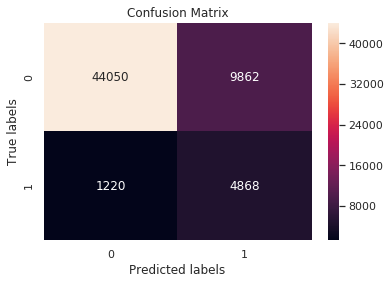

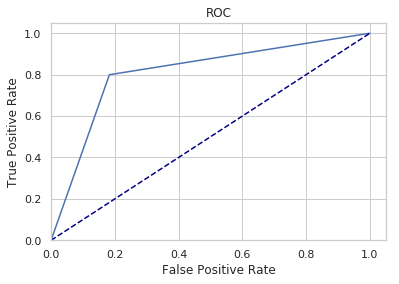

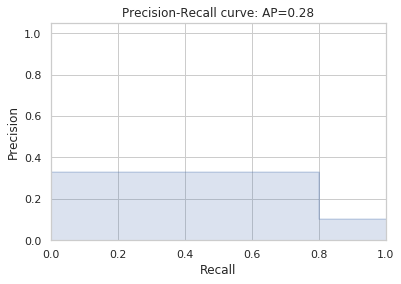

In [13]:
#calculating accuarcy
print(accuracy_score(y_pred, y_test), 1-accuracy_score(y_pred, y_test))
#(0.8611166666666666, 0.13888333333333336)

def plot_confusion_matrix(y_test, y_pred, normalize=True):
  
  cm = confusion_matrix(y_test, y_pred)
  
  if normalize:
    cm = cm / cm.sum(axis=1)[:, np.newaxis]

  ax= plt.subplot()
  sns.heatmap(cm, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix');


plot_confusion_matrix(y_test, y_pred, normalize=False)

print (classification_report(y_test,y_pred))
''''
              precision    recall  f1-score   support

           0       0.97      0.87      0.92     53912
           1       0.40      0.74      0.52      6088

    accuracy                           0.86     60000
   macro avg       0.68      0.81      0.72     60000
weighted avg       0.91      0.86      0.88     60000
'''
# generate auc score
AUC = roc_auc_score(y_test, probabilities['Probability'])
print(f'AUC: {AUC}')
#0.8078981072771728

# define variables for True Positive Rate and Falst Positive Rate & threshold value
TPR = dict()
FPR = dict()
THR = dict()
#FPR, TPR, THR = roc_curve(Y_test, predictTest)
FPR, TPR, THR = roc_curve(y_test, probabilities['Probability'])

plt.figure()
# plot the FPR as X-axis and TPR as Y-axis
plt.plot(FPR, TPR)
# plot the minimum line 
plt.plot([0,1], [0,1], color='navy', linestyle = '--')
# set X and Y limits
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
# mention lables for X and Y
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

average_precision = average_precision_score(y_test, probabilities['Probability'])


precision, recall, _ = precision_recall_curve(y_test, probabilities['Probability'])

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()

*I'm going to talk about marketing strategies for the false postives in based on the confusion matrix.*

Feature Importances

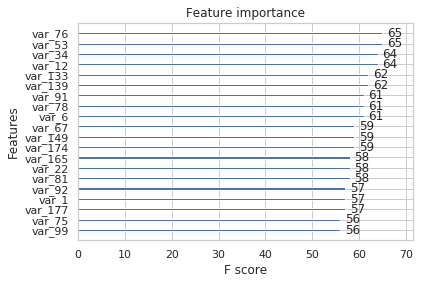

In [14]:
xgb.plot_importance(final_gb, max_num_features=20)
plt.show()

### Correlations

In [0]:
importances = final_gb.get_fscore()
#%%
importances_df = pd.DataFrame(data=list(importances.items()), columns=['Variable', 'Feature_Importance'])
importance_df =  importances_df.sort_values(by=['Feature_Importance'], ascending=False)
importance_df.head(50)
#%%
top_50_list_list = importance_df.iloc[:50, :1].values.tolist()
top_50 = [item for sublist in top_50_list_list for item in sublist]
var_col = top_50 + ['ID_code', 'target']
df_subset = df[var_col]
df_subset.head()
X_subset = df_subset.iloc[:, :50]
check = X_subset.values
#%%
corr = X_subset.corr(method='spearman')
#%%
corr_list = corr.values.tolist()
corr_list = [item for sublist in corr_list for item in sublist]
corr_list = [x for x in corr_list if x != 1]
#%%
# max: 0.009713658349534146
# min: -0.009844361358419677
#%%
X_subset = df_subset[top_50]
Y_subset  = df_subset.loc[:, df_subset.columns == 'target']
#%%


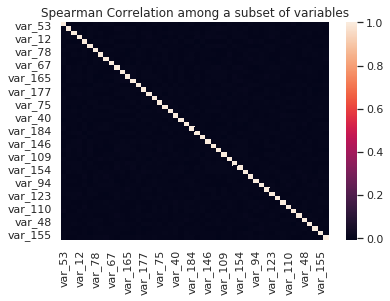

In [17]:
sns.heatmap(corr); plt.title('Spearman Correlation among a subset of variables');

# Submission

In [18]:
# predicting on test data
test = pd.read_csv('test.csv')
test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,-2.0248,-4.3554,13.9696,0.3458,7.5408,14.5001,7.7028,-19.0919,15.5806,16.1763,3.7088,18.8064,1.5899,3.0654,6.4509,14.1192,-9.4902,-2.1917,5.7107,3.7864,-1.7981,9.2645,2.0657,12.7753,11.3334,8.1462,-0.0610,3.5331,9.7804,...,5.9232,5.4113,3.8302,5.7380,-8.6105,22.9530,2.5531,-0.2836,4.3416,5.1855,4.2603,1.6779,29.0849,8.4685,18.1317,12.2818,-0.6912,10.2226,-5.5579,2.2926,-4.5358,10.3903,-15.4937,3.9697,31.3521,-1.1651,9.2874,-23.5705,13.2643,1.6591,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,-1.3809,-0.3310,14.1129,2.5667,5.4988,14.1853,7.0196,4.6564,29.1609,0.0910,12.1469,3.1389,5.2578,2.4228,16.2064,13.5023,-5.2341,-3.6648,5.7080,2.9965,-10.4720,11.4938,-0.9660,15.3445,10.6361,0.8966,6.7428,2.3421,12.8678,...,30.9641,5.6723,3.6873,13.0429,-10.6572,15.5134,3.2185,9.0535,7.0535,5.3924,-0.7720,-8.1783,29.9227,-5.6274,10.5018,9.6083,-0.4935,8.1696,-4.3605,5.2110,0.4087,12.0030,-10.3812,5.8496,25.1958,-8.8468,11.8263,-8.7112,15.9072,0.9812,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,8.3442,-4.7057,-3.0422,13.6751,3.8183,10.8535,14.2126,9.8837,2.6541,21.2181,20.8163,12.4666,12.3696,4.7473,2.7936,5.2189,13.5670,-15.4246,-0.1655,7.2633,3.4310,-9.1508,9.7320,3.1062,22.3076,11.9593,9.9255,4.0702,4.9934,8.0667,...,39.3654,5.5228,3.3159,4.3324,-0.5382,13.3009,3.1243,-4.1731,1.2330,6.1513,-0.0391,1.4950,16.8874,-2.9787,27.4035,15.8819,-10.9660,15.6415,-9.4056,4.4611,-3.0835,8.5549,-2.8517,13.4770,24.4721,-3.4824,4.9178,-2.0720,11.5390,1.1821,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,7.4578,0.0095,-5.0659,14.0526,13.5010,8.7660,14.7352,10.0383,-15.3508,2.1273,21.4797,14.5372,12.5527,2.9707,4.2398,13.7796,14.1408,1.0061,-1.3479,5.2570,6.5911,6.2161,9.5540,2.3628,10.2124,10.8047,-2.5588,6.0720,3.2613,16.5632,...,19.7251,5.3882,3.6775,7.4753,-11.0780,24.8712,2.6415,2.2673,7.2788,5.6406,7.2048,3.4504,2.4130,11.1674,14.5499,10.6151,-5.7922,13.9407,7.1078,1.1019,9.4590,9.8243,5.9917,5.1634,8.1154,3.6638,3.3102,-19.7819,13.4499,1.3104,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,7.1437,5.1025,-3.2827,14.1013,8.9672,4.7276,14.5811,11.8615,3.1480,18.0126,13.8006,1.6026,16.3059,6.7954,3.6015,13.6569,13.8807,8.6228,-2.2654,5.2255,7.0165,-15.6961,10.6239,-4.7674,17.5447,11.8668,3.0154,4.2546,6.7601,5.9613,...,22.8700,5.6688,6.1159,13.2433,-11.9785,26.2040,3.2348,-5.5775,5.7036,6.1717,-1.6039,-2.4866,17.2728,2.3640,14.0037,12.9165,-12.0311,10.1161,-8.7562,6.0889,-1.3620,10.3559,-7.4915,9.4588,3.9829,5.8580,8.3635,-24.8254,11.4928,1.6321,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [0]:
X_final = test.drop('ID_code', axis=1)
dtest_final = xgb.DMatrix(X_final.values, feature_names=final_gb.feature_names)
y_pred_final = final_gb.predict(dtest_final)

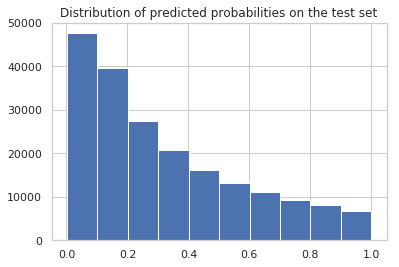

In [20]:
pd.Series(y_pred_final).hist(); plt.title('Distribution of predicted probabilities on the test set');

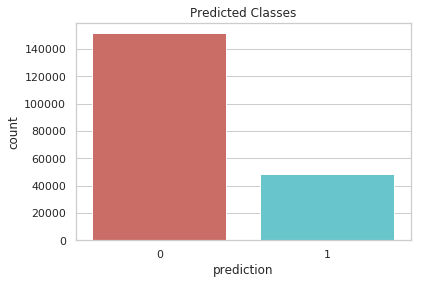

In [21]:
submission = pd.DataFrame({'id': test['ID_code'],
                           'prediction': np.array(y_pred_final > 0.5, dtype=int)})
sns.countplot('prediction', data=submission, palette='hls'); 
plt.title('Predicted Classes');

In [22]:
submission.to_csv('submission.csv', index=False)
submission.head()

,id,prediction
0,test_0,0
1,test_1,1
2,test_2,1
3,test_3,1
4,test_4,0


In [0]:
from google.colab import files
files.download('submission.csv')